# 🔺 Stock Price Movement Classification with XGBoost

In this notebook, we predict whether Tesla's stock price will go **up** or **down** the next day using technical indicators.

This is a **classification problem**, not regression — the model tries to predict the *direction* of price movement using:
- SMA (Simple Moving Average)
- EMA (Exponential Moving Average)
- RSI (Relative Strength Index)
- Volume

We'll train an XGBoost classifier and evaluate it using classification metrics like **accuracy**, **precision**, **recall**, and a **confusion matrix**.


In [1]:
!pip install yfinance ta scikit-learn xgboost --quiet


## 📊 Step 1: Download Tesla (TSLA) Stock Data

We’ll use the past 180 days of daily data, including Open, High, Low, Close, and Volume.


In [2]:
import yfinance as yf
import pandas as pd

# Download TSLA stock data
tsla = yf.download("TSLA", period="180d", interval="1d")
tsla = tsla[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
tsla.tail()


[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


Price,Open,High,Low,Close,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2025-04-11,251.839996,257.739990,241.360001,252.309998,128948100
2025-04-14,258.359985,261.799988,245.929993,252.350006,100135200
2025-04-15,249.910004,258.750000,247.539993,254.110001,79594300
2025-04-16,247.610001,251.970001,233.889999,241.550003,112378700
2025-04-17,243.470001,244.339996,237.679993,241.369995,83404800


## 🛠 Step 2: Add Technical Indicators

We will add:
- 10-day Simple Moving Average (SMA)
- 10-day Exponential Moving Average (EMA)
- 14-day Relative Strength Index (RSI)


In [3]:
import ta

tsla['SMA_10'] = ta.trend.sma_indicator(tsla['Close'].squeeze(), window=10)
tsla['EMA_10'] = ta.trend.ema_indicator(tsla['Close'].squeeze(), window=10)
tsla['RSI_14'] = ta.momentum.rsi(tsla['Close'].squeeze(), window=14)

tsla.dropna(inplace=True)
tsla.tail()


Price,Open,High,Low,Close,Volume,SMA_10,EMA_10,RSI_14
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,,,
Date,,,,,,,,
2025-04-11,251.839996,257.739990,241.360001,252.309998,128948100,254.914999,253.717503,46.467002
2025-04-14,258.359985,261.799988,245.929993,252.350006,100135200,254.234000,253.468867,46.478628
2025-04-15,249.910004,258.750000,247.539993,254.110001,79594300,252.799001,253.585437,47.023653
2025-04-16,247.610001,251.970001,233.889999,241.550003,112378700,248.678000,251.397176,43.610589
2025-04-17,243.470001,244.339996,237.679993,241.369995,83404800,246.087000,249.574052,43.561789


In [4]:
# --- Momentum Feature: Daily % Change ---
tsla['pct_change'] = tsla['Close'].pct_change()

# --- Lag Feature: Yesterday's RSI ---
tsla['RSI_14_lag1'] = tsla['RSI_14'].shift(1)

# --- MACD Features ---
macd = ta.trend.macd(tsla['Close'].squeeze())
macd_signal = ta.trend.macd_signal(tsla['Close'].squeeze())

tsla['MACD'] = macd
tsla['MACD_signal'] = macd_signal

# Drop new NaNs after adding features
tsla.dropna(inplace=True)


## 🎯 Step 3: Define Target Label (Price Up or Down)

- If tomorrow’s close is higher than today’s → label = 1 (UP)
- If lower or same → label = 0 (DOWN)

This creates a binary classification target.


In [5]:
import ta

tsla['SMA_10'] = ta.trend.sma_indicator(tsla['Close'].squeeze(), window=10)
tsla['EMA_10'] = ta.trend.ema_indicator(tsla['Close'].squeeze(), window=10)
tsla['RSI_14'] = ta.momentum.rsi(tsla['Close'].squeeze(), window=14)

# Drop any NaNs caused by indicators (first ~14 rows)
tsla.dropna(inplace=True)


## 🔢 Step 4: Feature Matrix & Scaling

We select the following features:
- SMA_10
- EMA_10
- RSI_14
- Volume

We'll scale them before feeding into XGBoost.


In [6]:
tsla['Target'] = (tsla['Close'].shift(-1) > tsla['Close']).astype(int)

# Drop last row — it has no future Close price
tsla.dropna(inplace=True)

# ✅ Preview to confirm it's working
print(tsla[['Close', 'SMA_10', 'RSI_14', 'Target']].tail())

Price            Close      SMA_10     RSI_14 Target
Ticker            TSLA                              
Date                                                
2025-04-11  252.309998  254.914999  46.466685      1
2025-04-14  252.350006  254.234000  46.478311      1
2025-04-15  254.110001  252.799001  47.023355      0
2025-04-16  241.550003  248.678000  43.610221      0
2025-04-17  241.369995  246.087000  43.561420      0


## ✂️ Step 5: Train/Test Split (Time-Aware)

To evaluate model performance realistically, we split the dataset into a **training set** and a **test set**.

- We do **not shuffle** the data to preserve the time order — this is critical for time series problems.
- The **training set** will be used to fit the model.
- The **test set** will represent unseen future data to evaluate predictive performance.
- All features are scaled using `StandardScaler` to ensure fair model treatment.

This sets us up for a reliable accuracy check before using the model in any trading simulation.


In [7]:
from sklearn.preprocessing import StandardScaler

# Define features and target
features = ['SMA_10', 'EMA_10', 'RSI_14', 'Volume',
            'pct_change', 'RSI_14_lag1', 'MACD', 'MACD_signal']
X = tsla[features].values
y = tsla['Target'].values

# Custom time-aware split (70% train, 30% test)
split_idx = int(len(X) * 0.7)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale features using only training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (84, 8), Test size: (37, 8)


## 🤖 Step 6: Train the XGBoost Classifier

We’ll now train an `XGBoostClassifier` on the training set to predict the next day's price movement direction.

XGBoost is a gradient-boosted decision tree model known for handling:
- Nonlinear relationships
- Noisy data
- Small to mid-size structured datasets

Once trained, we’ll use it to predict the class (up or down) on the test set.


In [8]:
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from collections import Counter
import numpy as np

# Balance class weights
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]

# Train model
model = XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict probabilities
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Sweep thresholds
thresholds = np.arange(0.3, 0.71, 0.01)
best_f1 = 0
best_thresh = 0.5

for t in thresholds:
    y_pred_temp = (y_proba > t).astype(int)
    f1 = f1_score(y_test, y_pred_temp)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print(f"✅ Best F1: {best_f1:.4f} at threshold {best_thresh:.2f}")

# Final prediction using best threshold
y_pred = (y_proba > best_thresh).astype(int)


✅ Best F1: 0.5625 at threshold 0.39


## 📈 Step 7: Evaluate Model Performance

Now we assess how well our model performs on unseen (test) data.

We'll use:
- **Confusion Matrix**: Breakdown of true positives, false positives, etc.
- **Classification Report**: Includes Accuracy, Precision, Recall, and F1 Score

These metrics help us understand if the model is:
- Accurately predicting up/down movement
- Biased toward one class
- Reliable enough to potentially backtest a trading strategy


✅ Classification Report:
              precision    recall  f1-score   support

        Down       0.67      0.67      0.67        21
          Up       0.56      0.56      0.56        16

    accuracy                           0.62        37
   macro avg       0.61      0.61      0.61        37
weighted avg       0.62      0.62      0.62        37



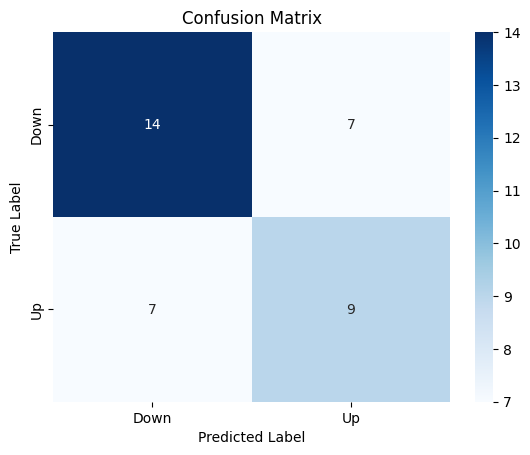

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Classification report
print("✅ Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Down", "Up"]))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


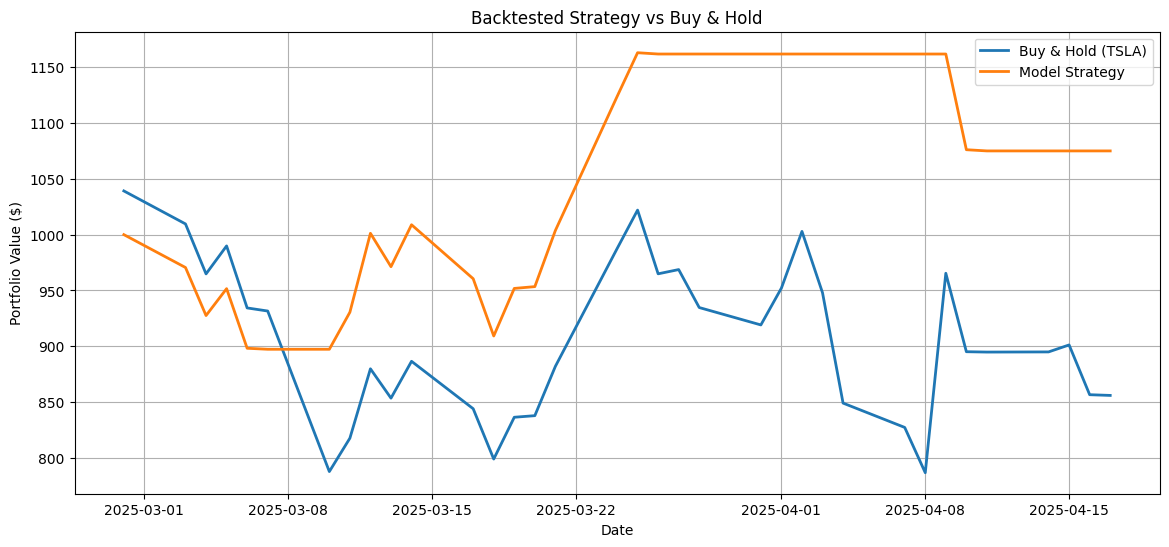


💰 Strategy Return: 7.49%
📉 Buy & Hold Return: -14.39%
📊 Win Rate: 25.71%
📈 Sharpe Ratio: 1.16


In [10]:
# 📈 Backtesting Strategy Based on Model Predictions

# Assumes `y_pred` contains final predictions on test set
# Assumes `y_test` aligns with X_test_scaled and index is preserved

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Reconstruct test set DataFrame with predictions ===
test_df = tsla.iloc[-len(y_test):].copy()  # last rows of original DataFrame

# Add predictions to DataFrame
test_df['Prediction'] = y_pred

# Shift prediction forward so it aligns with "next day's" return
test_df['Position'] = test_df['Prediction'].shift(1)  # today’s prediction is for tomorrow

# Compute daily returns
test_df['Market Return'] = test_df['Close'].pct_change()
test_df['Strategy Return'] = test_df['Market Return'] * test_df['Position']

# Apply transaction cost
cost = 0.001  # 0.1% per trade
test_df['Trades'] = test_df['Position'].diff().abs()
test_df['Strategy Return'] -= cost * test_df['Trades']

# Drop initial NA
test_df.dropna(inplace=True)

# === Calculate performance ===
initial_cash = 1000
market_curve = (1 + test_df['Market Return']).cumprod() * initial_cash
strategy_curve = (1 + test_df['Strategy Return']).cumprod() * initial_cash

# === Plot performance ===
plt.figure(figsize=(14,6))
plt.plot(market_curve.index, market_curve, label='Buy & Hold (TSLA)', linewidth=2)
plt.plot(strategy_curve.index, strategy_curve, label='Model Strategy', linewidth=2)
plt.title('Backtested Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# === Print metrics ===
total_return = strategy_curve.iloc[-1] / initial_cash - 1
buyhold_return = market_curve.iloc[-1] / initial_cash - 1
win_rate = np.mean(test_df['Strategy Return'] > 0)
sharpe = test_df['Strategy Return'].mean() / test_df['Strategy Return'].std() * np.sqrt(252)

print(f"\n💰 Strategy Return: {total_return:.2%}")
print(f"📉 Buy & Hold Return: {buyhold_return:.2%}")
print(f"📊 Win Rate: {win_rate:.2%}")
print(f"📈 Sharpe Ratio: {sharpe:.2f}")
